# Flappy Bird

In [1]:
# @ title Imports
from time import sleep
from typing import Tuple, Literal

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import clear_output
from deep_rl.environments.flappy_bird import FlappyBird
from deep_rl.shapes import Point, Rectangle
from deep_rl.terminal_renderer import BashRenderer

from src import (
    infer_parameters,
    TreeBasedAgent,
    repr_obs,
    repr_bars,
)

In [2]:
params = {"gravity": 0.05, "force_push": 0.1, "vx": 0.05}
env = FlappyBird(**params, prob_new_bar=1, max_height_bar=0.5)

In [3]:
# @ title Inferring the parameters
gravity, force_push, vx = infer_parameters(env)
assert np.allclose(
    [gravity, force_push, vx],
    (
        params["gravity"],
        params["force_push"],
        params["vx"],
    ),
    rtol=1e-3,
), "Parameters inference failed"

In [4]:
# @title Building the tree
env.reset()
(bird_x, bird_y, bird_vy), bars = env.step(0)[0]
tree_agent = TreeBasedAgent(gravity, force_push, vx, bars)
outcomes = tree_agent.predict(bird_x, bird_y, bird_vy)
assert (
    tree_agent.n_steps_computed + tree_agent.n_steps_saved
    == tree_agent.outcomes.shape[0]
), "Not all outcomes were the product of a proper computation"
print(
    f"\nNumber of leaves computed: {tree_agent.n_steps_computed}\n"
    f"Number of leave computation steps saved: {tree_agent.n_steps_saved}\n"
)
tree_agent.print_outcomes_stats()


Number of leaves computed: 572
Number of leave computation steps saved: 1476


Number of favorable outcomes:    526 / 2048  (25.68%)
- Probability of winning when standing still: 8.50%
- Probability of winning when jumping:        17.19%



## Experiments

In [5]:
def launch_experiment(
    environment: FlappyBird,
    rendering_size: Tuple[int, int] = (20, 40),
    time_between_frames: float = 0.1,
    clear_between_frames: bool = False,
    max_steps: int = 1000,
    print_additional_info: Literal["decisions", "trajectories"] | None = None,
    print_agent_bars: bool = False,
) -> Tuple[int, int]:
    step, total_reward = 0, 0
    renderer = BashRenderer(*rendering_size, clear_fn=lambda: clear_output(wait=True))

    agent = TreeBasedAgent(gravity, force_push, vx, max_bars=100)
    observation = environment.reset()

    for step in range(1, max_steps + 1):
        action = agent.act(observation)

        # printing some useful information
        agent.print_outcomes_stats()
        if print_additional_info == "decisions":
            agent.print_successful_decisions()
        elif print_additional_info == "trajectories":
            agent.print_successful_trajectories(*observation[0])

        # playing
        observation, reward, done = environment.step(action)
        print(
            f"\naction: {action}, reward: {reward}, observation: {repr_obs(observation)}"
        )
        # checking if the tree sees the same bars
        if step > 1 and print_agent_bars:
            print("\nBars the TreeBuilder sees:")
            print(repr_bars(agent.bars))

        total_reward += reward
        print(f"\nCumulated reward at step {step}: {total_reward:>3}.")
        if done:
            print(f"Simulation ended after {step} steps.")
            break

        # rendering the environment
        if clear_between_frames:
            renderer.clear()
        renderer.draw_list(environment.render())
        renderer.draw_title(f"Total reward : {total_reward}")
        renderer.render()
        sleep(time_between_frames)

        background = Rectangle(
            bot_left=Point(x=0, y=0),
            top_right=Point(x=1, y=1),
        )

    return total_reward, step

In [6]:
def launch_experiment_without_rendering(
    environment: FlappyBird,
    max_steps: int = 10000,
    verbose: bool = False,
) -> Tuple[int, int]:
    step, total_reward = 0, 0

    agent = TreeBasedAgent(gravity, force_push, vx, max_bars=100)
    observation = environment.reset()
    for step in range(1, max_steps + 1):
        # playing
        action = agent.act(observation)
        observation, reward, done = environment.step(action)
        if verbose:
            print(
                f"\naction: {action}, reward: {reward}, observation: {repr_obs(observation)}"
            )

        total_reward += reward
        if verbose:
            print(f"\nCumulated reward at step {step}: {total_reward:>3}.")
        if done:
            if verbose:
                print(f"Simulation ended after {step} steps.")
            break

    return total_reward, step

In [7]:
launch_experiment(env, print_additional_info="trajectories")


Number of favorable outcomes:    376 / 1024  (36.72%)
- Probability of winning when standing still: 18.16%
- Probability of winning when jumping:        18.55%


A few successful trajectories:
 -- (0.50, 0.50, 0.00) -> jumps to (0.55, 0.55, 0.05) -> jumps to (0.60, 0.65, 0.10) -> falls to (0.65, 0.70, 0.05) -> falls to (0.70, 0.70, 0.00) -> falls to (0.75, 0.65, -0.05) -> falls to (0.80, 0.55, -0.10) -> falls to (0.85, 0.40, -0.15) -> falls to (0.90, 0.20, -0.20) -> falls to (0.95, -0.05, -0.25) -> falls to (1.00, -0.35, -0.30)
 -- (0.50, 0.50, 0.00) -> jumps to (0.55, 0.55, 0.05) -> falls to (0.60, 0.55, 0.00) -> falls to (0.65, 0.50, -0.05) -> falls to (0.70, 0.40, -0.10) -> falls to (0.75, 0.25, -0.15) -> falls to (0.80, 0.05, -0.20) -> falls to (0.85, -0.20, -0.25) -> falls to (0.90, -0.50, -0.30) -> falls to (0.95, -0.85, -0.35) -> falls to (1.00, -1.25, -0.40)
 -- (0.50, 0.50, 0.00) -> jumps to (0.55, 0.55, 0.05) -> falls to (0.60, 0.55, 0.00) -> jumps to (0.65, 0.60, 0.05) -> j

(22, 81)



Reward over 500 experiments: 58.11 +/- 121.52 [-1.00, 444.00]
Number of steps: 181.67 +/- 348.70 [12.00, 1213.00]


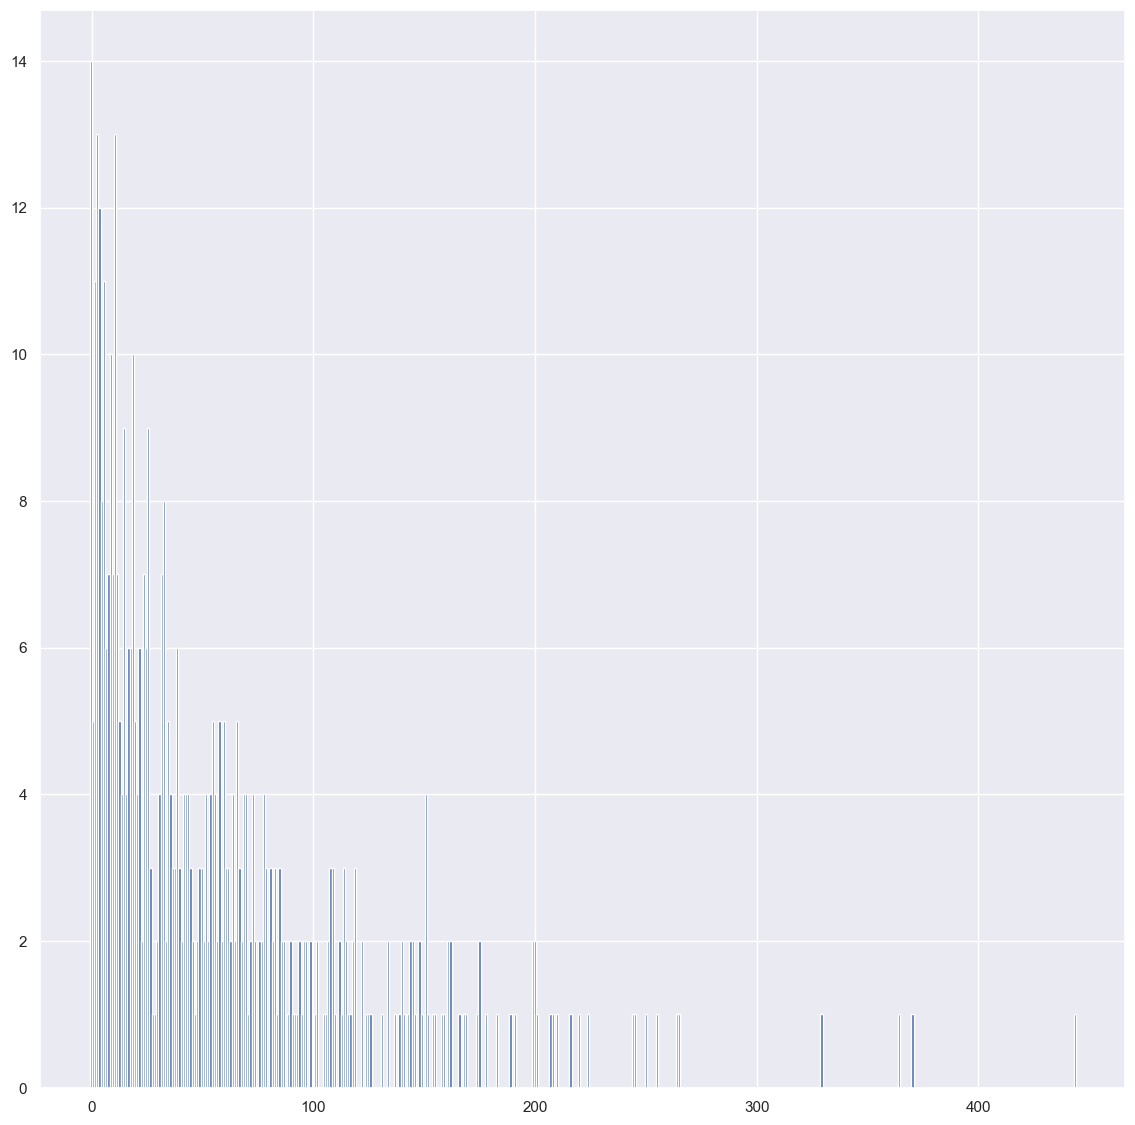

CPU times: user 2min 33s, sys: 979 ms, total: 2min 34s
Wall time: 2min 34s


In [8]:
%%time
n_experiments = 500  # @param {type:"slider", min:50, max:1000, step:10}

rewards = np.zeros(n_experiments)
n_steps = np.zeros(n_experiments)

for i in range(n_experiments):
    rewards[i], n_steps[i] = launch_experiment_without_rendering(env)
print(
    f"\n\nReward over {n_experiments} experiments: {rewards.mean():.2f} +/- {1.96 * rewards.std():.2f} "
    f"[{rewards.min():.2f}, {rewards.max():.2f}]"
)
print(
    f"Number of steps: {n_steps.mean():.2f} +/- {1.96 * n_steps.std():.2f} [{n_steps.min():.2f}, {n_steps.max():.2f}]"
)

sns.set_theme()
plt.figure(figsize=(12, 12))
plt.hist(rewards, bins=int(rewards.max()))
plt.show()